# Group 14 - Project FP01
## Time series anomaly detection - DAGMM

This project aims at investigating the current state-of-the-arts TAD scenario.

In [ ]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [1]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc

from dataset import get_df_action, get_features_ts, get_train_test_data
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import Confidence, anomaly_detection_metric, compute_metrics

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

2024-07-21 19:53:57.020355: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 19:53:57.049431: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 19:53:57.049457: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 19:53:57.049476: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 19:53:57.055045: I tensorflow/core/platform/cpu_feature_g

In [2]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [3]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)


# COLLISION DATA
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [4]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1)
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
Computing features.


Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 319.3763406276703 seconds ---


In [5]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision)
X_train1, y_train1, X_test1, y_test1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)
X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (164, 2200)
y_test shape: (164,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (164, 96)
y_test shape: (164,)
X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (141, 2200)
y_test shape: (141,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (141, 96)
y_test shape: (141,)


## DAGMM


In [6]:
from algorithms.dagmm import DAGMM

classifier = DAGMM(
    num_epochs=100,
    lambda_energy=0.1,
    lambda_cov_diag=0.005,
    lr=1e-3,
    batch_size=64,
    gmm_k=4,
    normal_percentile=80,
    sequence_length=30,
    autoencoder_type=DAGMM.AutoEncoder.LSTM,  # Using LSTM autoencoder
    hidden_size=32,
    autoencoder_args={
        'n_layers': (2, 2),
        'use_bias': (True, True),
        'dropout': (0.2, 0.2)
    },
    seed=42,
    gpu=None,  # Set to None for CPU, or specify GPU index if available
    details=True
)

# Train the DAGMM on normal data
classifier.fit(X_train)
print("DAGMM training completed.")


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


DAGMM training completed.


### Anomaly Detection

Anomaly prediction completed.


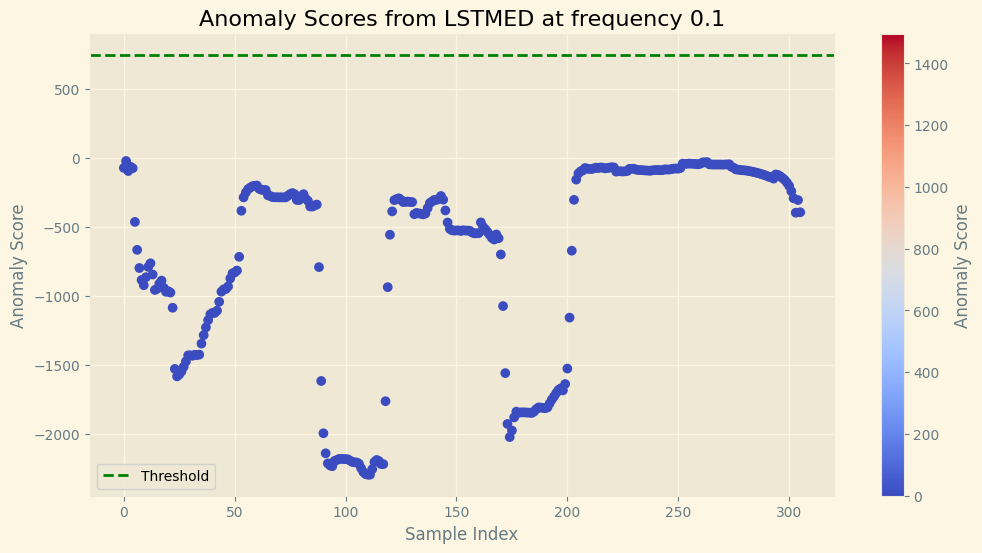

Number of anomalies detected: 0


Anomaly prediction completed.


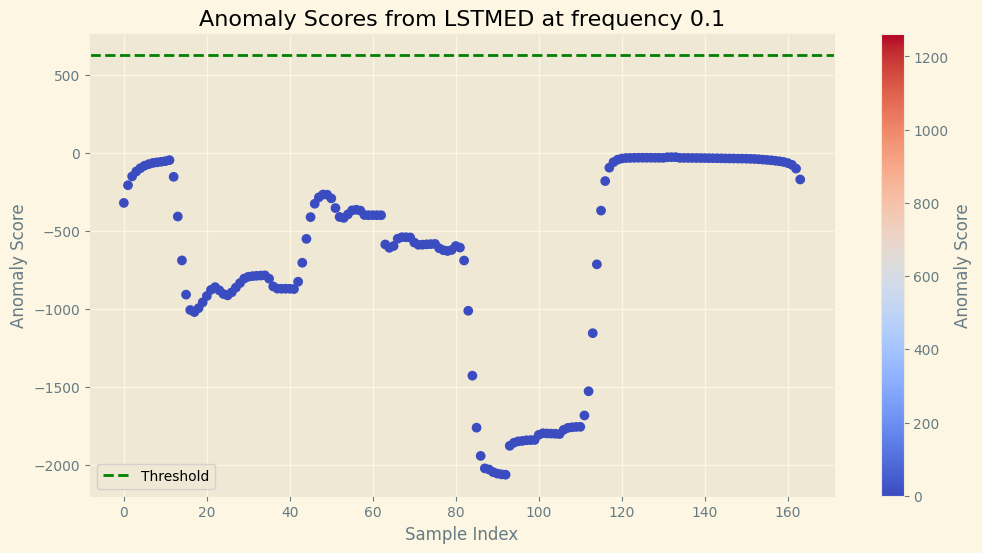

Number of anomalies detected: 0


Anomaly prediction completed.


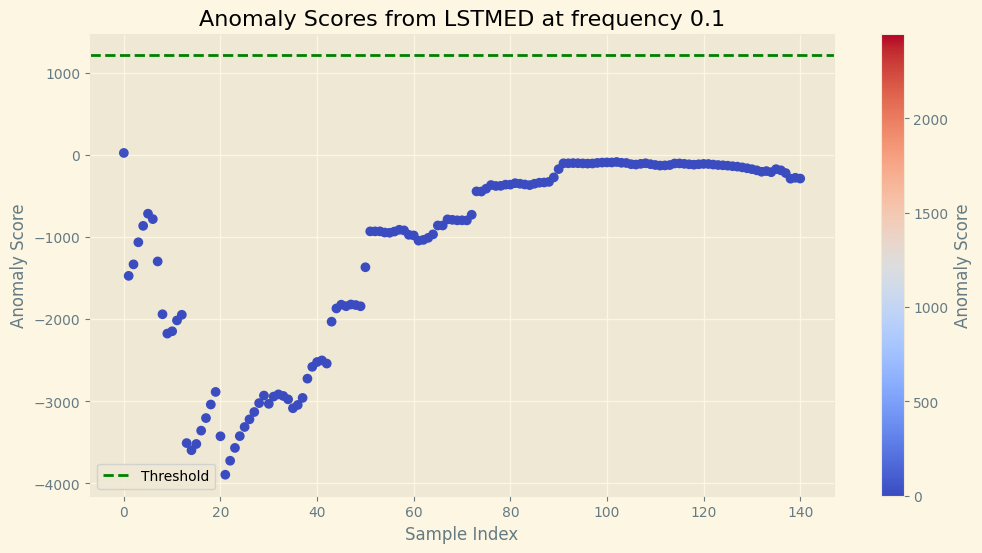

Number of anomalies detected: 0


In [8]:
anomaly_scores, anomalies_detected = plot_anomalies(classifier, X_test, y_test, freq)
anomaly_scores1, anomalies_detected1 = plot_anomalies(classifier, X_test1, y_test1, freq)
anomaly_scores5, anomalies_detected5 = plot_anomalies(classifier, X_test5, y_test5, freq)

In [9]:
anomaly_scores, y_test_binary = compute_metrics(classifier, X_test, y_test)
anomaly_scores1, y_test_binary1 = compute_metrics(classifier, X_test1, y_test1)
anomaly_scores5, y_test_binary5 = compute_metrics(classifier, X_test5, y_test5)

Anomaly scores statistics:
Mean: -708.1929028127144
Std: 728.14541011347
Min: -2298.6764707485836
Max: -22.608707427978516
ROC AUC Score: 0.9878
Detected anomaly class: 23
Threshold: 748.0979
F1 Score: 0.0000
Accuracy: 0.9804
Precision: 0.0000
Recall: 0.0000
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       300
           1       0.00      0.00      0.00         6

    accuracy                           0.98       306
   macro avg       0.49      0.50      0.50       306
weighted avg       0.96      0.98      0.97       306



Anomaly scores statistics:
Mean: -640.3016706548227
Std: 635.7035246790047
Min: -2061.2063712276517
Max: -25.510559050242104
ROC AUC Score: 1.0000
Detected anomaly class: 20
Threshold: 631.1054
F1 Score: 0.0000
Accuracy: 0.9817
Precision: 0.0000
Recall: 0.0000
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       161
           1       0.00      0.00      0.00         3

    accuracy                           0.98       164
   macro avg       0.49      0.50      0.50       164
weighted avg       0.96      0.98      0.97       164



Anomaly scores statistics:
Mean: -1122.8828022433022
Std: 1173.7026250987794
Min: -3893.1674132780595
Max: 27.63102149963379
ROC AUC Score: 0.9855
Detected anomaly class: 17
Threshold: 1224.5224
F1 Score: 0.0000
Accuracy: 0.9787
Precision: 0.0000
Recall: 0.0000
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       138
           1       0.00      0.00      0.00         3

    accuracy                           0.98       141
   macro avg       0.49      0.50      0.49       141
weighted avg       0.96      0.98      0.97       141



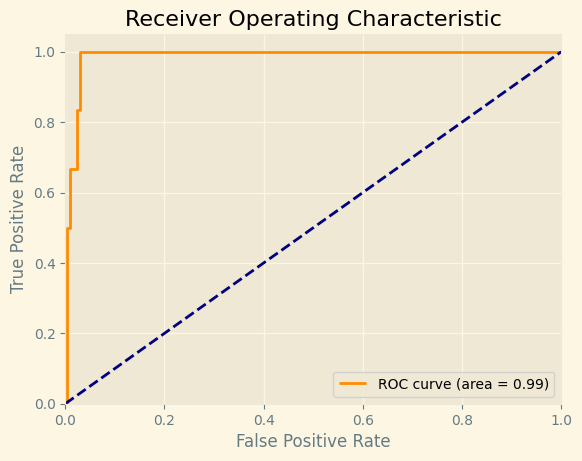

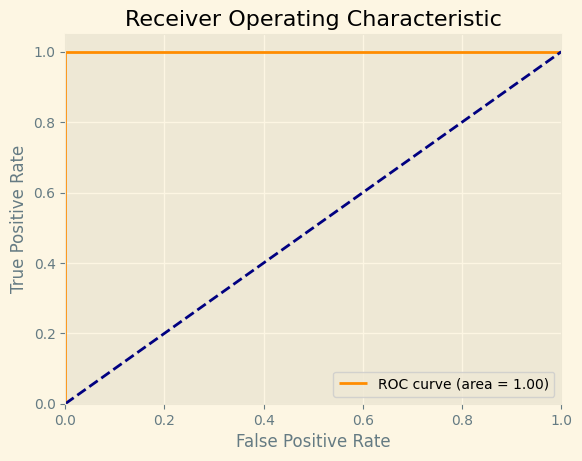

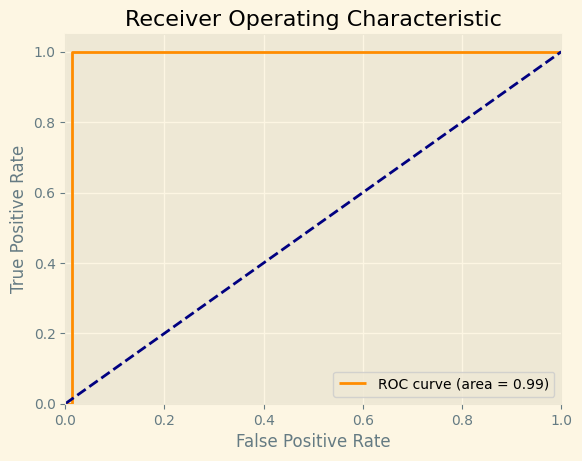

In [10]:
plot_roc_curve(y_test_binary, anomaly_scores)
plot_roc_curve(y_test_binary1, anomaly_scores1)
plot_roc_curve(y_test_binary5, anomaly_scores5)

## Map anomalies to original time series

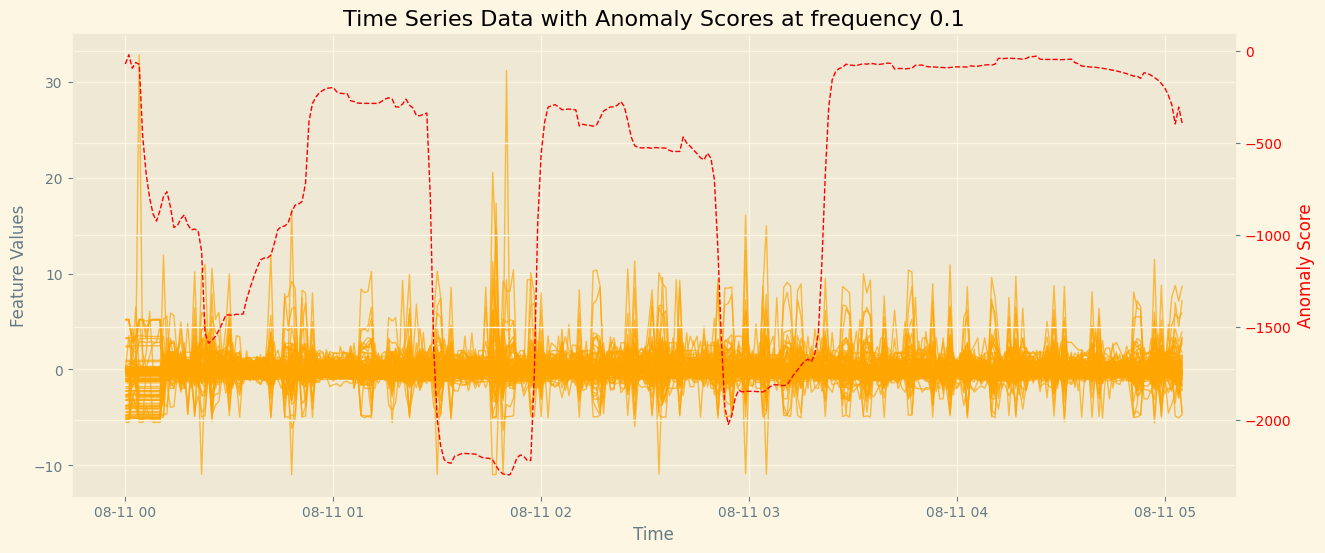

Top 0 Anomalies:
Empty DataFrame
Columns: [timestamp, anomaly_score, machine_nameKuka Robot_apparent_power-_Average power, machine_nameKuka Robot_apparent_power-_Variance, machine_nameKuka Robot_current-_Min, machine_nameKuka Robot_phase_angle-_Average power, machine_nameKuka Robot_phase_angle-_Variance, machine_nameKuka Robot_power-_ECDF Percentile_0, machine_nameKuka Robot_power-_Min, machine_nameKuka Robot_power_factor-_Histogram_9, machine_nameKuka Robot_reactive_power-_Absolute energy, machine_nameKuka Robot_reactive_power-_ECDF Percentile_0, machine_nameKuka Robot_reactive_power-_ECDF Percentile_1, machine_nameKuka Robot_reactive_power-_Mean absolute deviation, sensor_id1_AccX-_Histogram_5, sensor_id1_AccX-_Histogram_7, sensor_id1_AccY-_Interquartile range, sensor_id1_AccY-_Kurtosis, sensor_id1_AccZ-_Average power, sensor_id1_AngX-_Kurtosis, sensor_id1_AngX-_Max, sensor_id1_AngX-_Median absolute deviation, sensor_id1_AngY-_ECDF Percentile_1, sensor_id1_AngY-_Median, sensor_id1_An

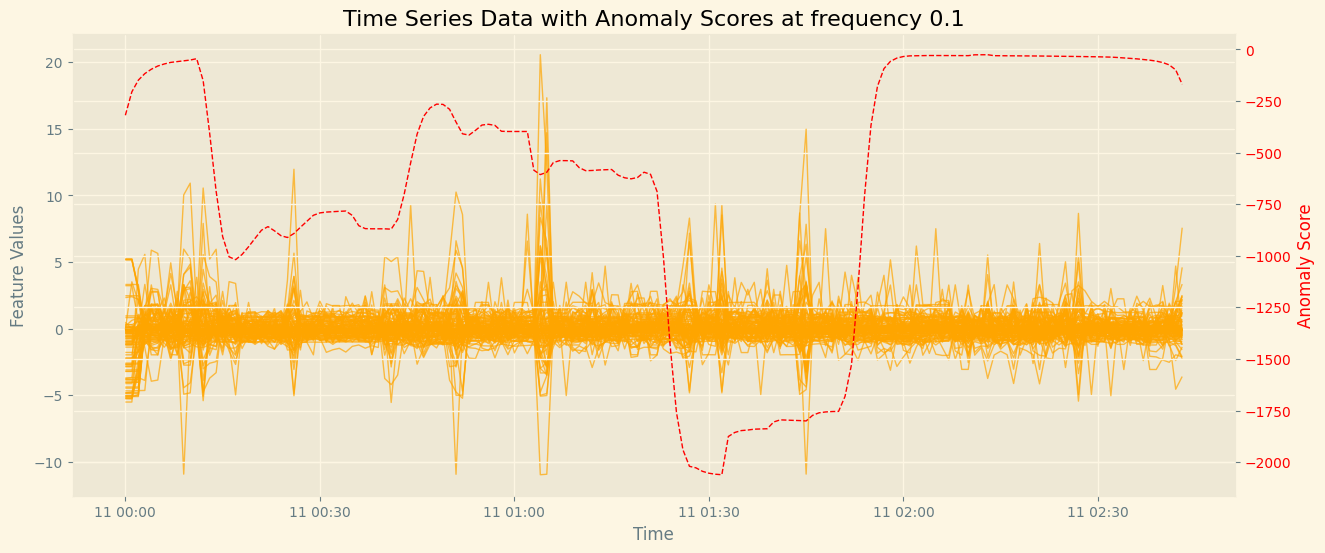

Top 0 Anomalies:
Empty DataFrame
Columns: [timestamp, anomaly_score, machine_nameKuka Robot_apparent_power-_Average power, machine_nameKuka Robot_apparent_power-_Variance, machine_nameKuka Robot_current-_Min, machine_nameKuka Robot_phase_angle-_Average power, machine_nameKuka Robot_phase_angle-_Variance, machine_nameKuka Robot_power-_ECDF Percentile_0, machine_nameKuka Robot_power-_Min, machine_nameKuka Robot_power_factor-_Histogram_9, machine_nameKuka Robot_reactive_power-_Absolute energy, machine_nameKuka Robot_reactive_power-_ECDF Percentile_0, machine_nameKuka Robot_reactive_power-_ECDF Percentile_1, machine_nameKuka Robot_reactive_power-_Mean absolute deviation, sensor_id1_AccX-_Histogram_5, sensor_id1_AccX-_Histogram_7, sensor_id1_AccY-_Interquartile range, sensor_id1_AccY-_Kurtosis, sensor_id1_AccZ-_Average power, sensor_id1_AngX-_Kurtosis, sensor_id1_AngX-_Max, sensor_id1_AngX-_Median absolute deviation, sensor_id1_AngY-_ECDF Percentile_1, sensor_id1_AngY-_Median, sensor_id1_An

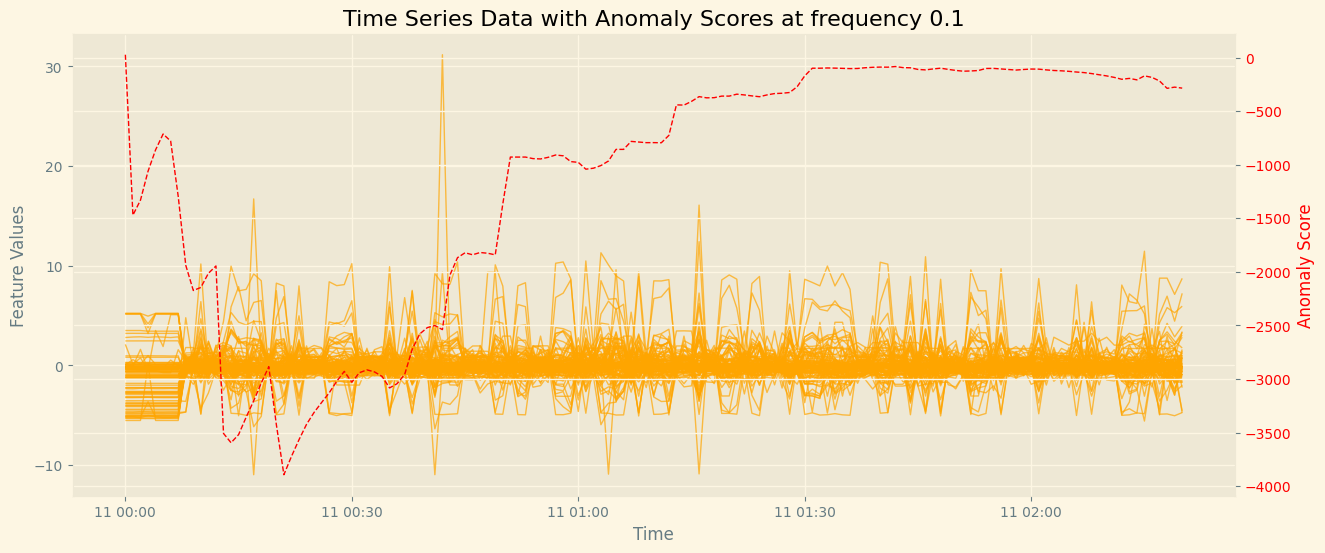

Top 0 Anomalies:
Empty DataFrame
Columns: [timestamp, anomaly_score, machine_nameKuka Robot_apparent_power-_Average power, machine_nameKuka Robot_apparent_power-_Variance, machine_nameKuka Robot_current-_Min, machine_nameKuka Robot_phase_angle-_Average power, machine_nameKuka Robot_phase_angle-_Variance, machine_nameKuka Robot_power-_ECDF Percentile_0, machine_nameKuka Robot_power-_Min, machine_nameKuka Robot_power_factor-_Histogram_9, machine_nameKuka Robot_reactive_power-_Absolute energy, machine_nameKuka Robot_reactive_power-_ECDF Percentile_0, machine_nameKuka Robot_reactive_power-_ECDF Percentile_1, machine_nameKuka Robot_reactive_power-_Mean absolute deviation, sensor_id1_AccX-_Histogram_5, sensor_id1_AccX-_Histogram_7, sensor_id1_AccY-_Interquartile range, sensor_id1_AccY-_Kurtosis, sensor_id1_AccZ-_Average power, sensor_id1_AngX-_Kurtosis, sensor_id1_AngX-_Max, sensor_id1_AngX-_Median absolute deviation, sensor_id1_AngY-_ECDF Percentile_1, sensor_id1_AngY-_Median, sensor_id1_An

In [11]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)
plot_anomalies_over_time(X_test1, anomaly_scores1, anomalies_detected1, freq)
plot_anomalies_over_time(X_test5, anomaly_scores5, anomalies_detected5, freq)